# Development of TDI filter
Some aPCI studies will may want as a diagnostic, comparison, or reference, a representation of kernel that is applied by the TDI algorithm, or some approximant.  

## Reverse engineering the TDI kernel
We had tools that could be applied for this from ground up in the old pylisa code, but it would be most valuable to be able to match with the actual kernels used in pyTDI sometimes.   Getting all the conventions and details right can be hard.  I did not notice a straightforward way to get this kernel info from the pyTDI code functions, because that isn't really how the calculation is organized at least at top level.  Fortunately it should be straightforward to extract this from the pyTDI code as a black box by probing it's impulse response.

In [1]:
from pytdi.michelson import X1, Y1, Z1, X2, Y2, Z2
from pytdi import Data
import h5py
import numpy as np
import copy
import pcipy

if 0:
    datadir = "/data/jgbaker/software/pylisa/data/"
    orbits = datadir+"keplerian-orbits.h5"
    workdir = datadir+"/simulations/"
    noise_file_base = "2025-07-01_19h38_laser_tm_oms_"
    gw_file_base = "2025-07-01_19h34_"
    dtpath = "2024-04-10_18h14_"
if 1: 
    datadir = "/data/jgbaker/software/pcipy/data"
    workdir = datadir+"/simulations/"
    if 1:
        orbits = workdir+"keplerian-orbits.h5"
        noise_file_base = "2025-04-07_keplerian_locking_N1-12_laser_tm_oms_"
        gw_file_base = "2025-04-07_keplerian_"
    else:
        orbits = workdir+"equalarm-orbits.h5"
        noise_file_base = "2025-04-07_equalarm_locking_N1-12_laser_tm_oms_"
        gw_file_base = "2025-04-07_equalarm_"

In [2]:
##This is the code for computing TDI as we do it in noise_simulation:
if 0:  #the code is just to look at
    data_noise = Data.from_instrument(instr)
    if args.tdi == '2':
        X, Y, Z = X2, Y2, Z2
    else:
        X, Y, Z = X1, Y1, Z1
    # Build other 2.0 Michelson variables
    X_data = X.build(**data_noise.args)
    Y_data = Y.build(**data_noise.args)
    Z_data = Z.build(**data_noise.args)
    # Apply TDI 2.0
    x_noise = X_data(data_noise.measurements)
    y_noise = Y_data(data_noise.measurements)
    z_noise = Z_data(data_noise.measurements)

In [3]:
# If we use a file
#simpath = workdir + dtpath + 'measurements_4Hz.h5'
simpath = workdir + noise_file_base + 'measurements_4Hz.h5'
# load hdf5 file to read data attrs
sim = h5py.File(simpath, 'r')

# load data
data_noise = Data.from_instrument(simpath)

fs = data_noise.fs

You are using a measurement file in a version that might not be fully supported


In [4]:
# Build other 2.0 Michelson variables
X_data_op = X2.build(**data_noise.args)
Y_data_op = Y2.build(**data_noise.args)
Z_data_op = Z2.build(**data_noise.args)

X_n_orig=X_data_op(data_noise.measurements)

In [5]:

#Test that we can work-with and reconstruct measurements and TDI for shorter series
#REF measurements = {f'isi_{link}': dset[:,ilink] for ilink, link in enumerate(links)}
mosas_order = ['12', '23', '31', '13', '21', '32']

n=20000
n=2000
#make modified version of the data_noise args
newargs=copy.deepcopy(data_noise.args)
for k in newargs['delays'].keys():
    #print(k,newargs['delays'][k].shape,newargs['delay_derivatives'][k].shape)
    newargs['delays'][k]=newargs['delays'][k][:n]
    newargs['delay_derivatives'][k]=newargs['delay_derivatives'][k][:n]
#X_data_op_short = X2.build(**newargs)
XYZ_ops=[chan.build(**newargs) for chan in [X2,Y2,Z2]]
display(newargs)

measurements_short=copy.deepcopy(data_noise.measurements)
for k in measurements_short.keys():
    #print(k,measurements[k].shape)
    measurements_short[k]=measurements_short[k][:n]
    
X_n_short=XYZ_ops[0](measurements_short)

print(X_n_orig[:n]-X_n_short,np.std(X_n_orig[:n]-X_n_short))
print(X_n_short)

{'delays': {'d_12': array([-8.69228120e-27, -9.40037481e-10,  3.97419807e-08, ...,
          8.31922118e+00,  8.31922118e+00,  8.31922118e+00], shape=(2000,)),
  'd_23': array([-8.68447913e-27, -9.39193716e-10,  3.97063088e-08, ...,
          8.31175077e+00,  8.31175077e+00,  8.31175077e+00], shape=(2000,)),
  'd_31': array([-8.71776946e-27, -9.42793940e-10,  3.98585155e-08, ...,
          8.34361340e+00,  8.34361340e+00,  8.34361340e+00], shape=(2000,)),
  'd_13': array([-8.71690343e-27, -9.42700282e-10,  3.98545559e-08, ...,
          8.34278454e+00,  8.34278454e+00,  8.34278454e+00], shape=(2000,)),
  'd_32': array([-8.68619889e-27, -9.39379701e-10,  3.97141717e-08, ...,
          8.31339672e+00,  8.31339672e+00,  8.31339672e+00], shape=(2000,)),
  'd_21': array([-8.69141501e-27, -9.39943805e-10,  3.97380204e-08, ...,
          8.31839216e+00,  8.31839216e+00,  8.31839216e+00], shape=(2000,))},
 'fs': np.float64(4.0),
 'delay_derivatives': {'d_12': array([-3.76014992e-09,  7.9483961

[0. 0. 0. ... 0. 0. 0.] 0.0
[-1.34653796e-38 -5.27819813e-20  7.23014089e-18 ...  5.12004389e+00
 -1.89218652e+00 -1.02047981e+00]


In [6]:
#now let's hack that process to get the zero-responses
measurements_z=copy.deepcopy(measurements_short)
for link in mosas_order:
    name=f'isi_{link}'
    data=np.zeros((n,))
    #print(name,data.shape,'\n',data)
    measurements_z[name]=data
print('computing TDI')
XYZ_z=np.array([op(measurements_z) for op in XYZ_ops])
print(XYZ_z)

computing TDI
[[ 1.01953440e-41  4.10944745e-23 -5.60359437e-21 ... -3.17184134e-05
   1.64301633e-05  2.02833073e-04]
 [-3.13382885e-42 -1.15331561e-23  1.59369924e-21 ...  8.53764197e-05
   5.34543036e-05  3.71046638e-06]
 [-7.03633560e-42 -2.94644289e-23  3.99638515e-21 ...  1.21291824e-05
   1.94248093e-04 -1.65507843e-04]]


In [7]:
#now let's hack that process to get the single-point-impulse-responses
i0=1000
XYZ_1={}
for link in mosas_order:
    print(link)
    measurements_1=copy.deepcopy(measurements_z)
    name=f'isi_{link}'
    #print(name,data.shape,'\n',data)
    measurements_1[name][i0]=1
    XYZ_z=np.array([op(measurements_1) for op in XYZ_ops])
    XYZ_1[link]=np.array([op(measurements_z) for op in XYZ_ops])-XYZ_z
display(XYZ_1)

12
23
31
13
21
32


{'12': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], shape=(3, 2000)),
 '23': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], shape=(3, 2000)),
 '31': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], shape=(3, 2000)),
 '13': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], shape=(3, 2000)),
 '21': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], shape=(3, 2000)),
 '32': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], shape=(3, 2000))}

In [8]:
minmaxs=[]
for link in mosas_order:
    for i in range(3):
        nz=np.nonzero(XYZ_1[link][i])[0]
        minmax = [min(nz),max(nz)] if len(nz)>0 else ''
        print(link,'XYZ'[i],len(nz),minmax)
        if len(nz)>0:minmaxs+=[minmax]
first=min([minmax[0] for minmax in minmaxs])
last=max([minmax[1] for minmax in minmaxs])
length=last+1-first
print('length,first,last',length,first,last)
        

12 X 97 [np.int64(1000), np.int64(1216)]
12 Y 128 [np.int64(1018), np.int64(1248)]
12 Z 0 
23 X 0 
23 Y 97 [np.int64(1000), np.int64(1215)]
23 Z 128 [np.int64(1018), np.int64(1249)]
31 X 128 [np.int64(1018), np.int64(1249)]
31 Y 0 
31 Z 97 [np.int64(1000), np.int64(1215)]
13 X 97 [np.int64(1000), np.int64(1215)]
13 Y 0 
13 Z 128 [np.int64(1018), np.int64(1249)]
21 X 128 [np.int64(1018), np.int64(1249)]
21 Y 97 [np.int64(1000), np.int64(1215)]
21 Z 0 
32 X 0 
32 Y 128 [np.int64(1018), np.int64(1248)]
32 Z 97 [np.int64(1000), np.int64(1215)]
length,first,last 250 1000 1249


In [9]:
kernels=np.array([XYZ_1[link][:,first:last+1] for link in mosas_order]).transpose((1,0,2))
print(kernels.shape)

(3, 6, 250)


In [10]:
###Now we reorganize pack that all into a neat bundle
def compute_TDI_kernel(noise_data,i0=0,nleft=500,nright=1000):

    assert i0-nleft>=0, "out of range"
    mosas_order = ['12', '23', '31', '13', '21', '32']

    #make modified version of the data_noise args
    newargs=copy.deepcopy(noise_data.args)
    for k in newargs['delays'].keys():
        #print(k,newargs['delays'][k].shape,newargs['delay_derivatives'][k].shape)
        newargs['delays'][k]=newargs['delays'][k][i0-nleft:i0+nright]
        newargs['delay_derivatives'][k]=newargs['delay_derivatives'][k][i0-nleft:i0+nright]
    XYZ_ops=[chan.build(**newargs) for chan in [X2,Y2,Z2]]
    #display(newargs)

    #Compute the zero-response for the relevant stretch of data
    measurements_z=copy.deepcopy(noise_data.measurements)
    for k in measurements_z.keys():
        #print(k,measurements[k].shape)
        measurements_z[k]=measurements_z[k][i0-nleft:i0+nright]

    for link in mosas_order:
        name=f'isi_{link}'
        data=np.zeros((nleft+nright,))
        measurements_z[name]=data
    #print('computing TDI')
    XYZ_z=np.array([op(measurements_z) for op in XYZ_ops])
    #print(XYZ_z)
    
    #now get the single-point-impulse-responses
    XYZ_1={}
    minmaxs=[]
    for link in mosas_order:
        #print(link)
        measurements_1=copy.deepcopy(measurements_z)
        name=f'isi_{link}'
        #print(name,data.shape,'\n',data)
        measurements_1[name][nleft]=1
        XYZ_z=np.array([op(measurements_z) for op in XYZ_ops])
        XYZ_1[link]=np.array([op(measurements_1) for op in XYZ_ops])-XYZ_z
        for i in range(3):
            nz=np.nonzero(XYZ_1[link][i])[0]
            minmax = [min(nz),max(nz)] if len(nz)>0 else ''
            #print(link,'XYZ'[i],len(nz),minmax)
            if len(nz)>0:minmaxs+=[minmax]
    #display(XYZ_1)
    first=min([minmax[0] for minmax in minmaxs])
    last=max([minmax[1] for minmax in minmaxs])
    length=last+1-first
    print('length,first,last',length,first,last)
    
    kernel=np.zeros((3,6,length))
    for ilink in range(len(mosas_order)):
        link=mosas_order[ilink]
        for i in range(3):
            kernel[:,ilink,:]=XYZ_1[link][:,first:last+1]
        #print('shape change:',XYZ_1[link].shape,kernel[link].shape)
    ioff=nleft-first
    print('ioff',ioff)
    #display(kernel)
    return ioff, kernel.transpose(0,2,1)[:,::-1,:]    


In [11]:
#Read data from file
simpath = workdir + noise_file_base + 'measurements_4Hz.h5'
# load hdf5 file to read data attrs
sim = h5py.File(simpath, 'r')
# load data
data_noise = Data.from_instrument(simpath)

You are using a measurement file in a version that might not be fully supported


In [12]:
compute_TDI_kernel(data_noise,i0=1000,nleft=1000,nright=2000)

length,first,last 250 1000 1249
ioff 0


(np.int64(0),
 array([[[ 0.00000000e+00,  0.00000000e+00, -4.19412469e-11,
           0.00000000e+00,  5.60906305e-11,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  1.38813327e-09,
           0.00000000e+00, -1.85724508e-09,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00, -2.23327687e-08,
           0.00000000e+00,  2.98949082e-08,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           1.00000000e+00,  0.00000000e+00,  0.00000000e+00]],
 
        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-3.61025110e-11,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  3.

In [13]:
ioff,s1000=compute_TDI_kernel(data_noise,i0=1000,nleft=100,nright=500)

length,first,last 250 100 349
ioff 0


In [14]:
ioff,s2000=compute_TDI_kernel(data_noise,i0=2000,nleft=100,nright=500);print(ioff)
#ioff,s4000=compute_TDI_kernel(data_noise,i0=4000,nleft=100,nright=500);print(ioff)
#ioff,s8000=compute_TDI_kernel(data_noise,i0=8000,nleft=100,nright=500);print(ioff)
ioff,s16000=compute_TDI_kernel(data_noise,i0=16000,nleft=100,nright=500);print(ioff)
#ioff,s32000=compute_TDI_kernel(data_noise,i0=32000,nleft=100,nright=500);print(ioff)
#ioff,s64000=compute_TDI_kernel(data_noise,i0=64000,nleft=100,nright=500);print(ioff)
ioff,s128000=compute_TDI_kernel(data_noise,i0=128000,nleft=100,nright=500);print(ioff)
#ioff,s256000=compute_TDI_kernel(data_noise,i0=256000,nleft=100,nright=500);print(ioff)
ioff,s512000=compute_TDI_kernel(data_noise,i0=512000,nleft=100,nright=500);print(ioff)

length,first,last 250 100 349
ioff 0
0
length,first,last 250 100 349
ioff 0
0
length,first,last 250 100 349
ioff 0
0
length,first,last 250 100 349
ioff 0
0


In [15]:
def ip(a,b):
    return np.sum(a*b)
def norm(a):
    return ip(a,a)
def ac(a,b):
    return ip(a,b)/np.sqrt(norm(a)*norm(b))

In [16]:
print(s1000[0].shape)

(250, 6)


In [17]:
def ac_matrix(a,b): return [[ac(a[i],b[j]) for i in range(3)] for j in range(3)]
display(ac_matrix(s1000,s1000))
display(ac_matrix(s2000,s2000))
display(ac_matrix(s1000,s2000))

[[np.float64(1.0), np.float64(0.0), np.float64(0.0)],
 [np.float64(0.0), np.float64(1.0), np.float64(0.0)],
 [np.float64(0.0), np.float64(0.0), np.float64(1.0)]]

[[np.float64(1.0), np.float64(0.0), np.float64(0.0)],
 [np.float64(0.0), np.float64(1.0), np.float64(0.0)],
 [np.float64(0.0), np.float64(0.0), np.float64(1.0)]]

[[np.float64(0.9999999999626142), np.float64(0.0), np.float64(0.0)],
 [np.float64(0.0), np.float64(0.9999999999748895), np.float64(0.0)],
 [np.float64(0.0), np.float64(0.0), np.float64(0.9999999998775555)]]

In [18]:
display(ac_matrix(s1000,s1000))
display(ac_matrix(s16000,s16000))
display(ac_matrix(s1000,s16000))

[[np.float64(1.0), np.float64(0.0), np.float64(0.0)],
 [np.float64(0.0), np.float64(1.0), np.float64(0.0)],
 [np.float64(0.0), np.float64(0.0), np.float64(1.0)]]

[[np.float64(1.0), np.float64(0.0), np.float64(0.0)],
 [np.float64(0.0), np.float64(1.0), np.float64(0.0)],
 [np.float64(0.0), np.float64(0.0), np.float64(1.0)]]

[[np.float64(0.9999999915994016), np.float64(0.0), np.float64(0.0)],
 [np.float64(0.0), np.float64(0.9999999943509441), np.float64(0.0)],
 [np.float64(0.0), np.float64(0.0), np.float64(0.999999972430785)]]

In [19]:
display(ac_matrix(s1000,s1000))
display(ac_matrix(s128000,s128000))
display(ac_matrix(s1000,s128000))

[[np.float64(1.0), np.float64(0.0), np.float64(0.0)],
 [np.float64(0.0), np.float64(1.0), np.float64(0.0)],
 [np.float64(0.0), np.float64(0.0), np.float64(1.0)]]

[[np.float64(1.0), np.float64(0.0), np.float64(0.0)],
 [np.float64(0.0), np.float64(1.0), np.float64(0.0)],
 [np.float64(0.0), np.float64(0.0), np.float64(1.0)]]

[[np.float64(0.9999994041678013), np.float64(0.0), np.float64(0.0)],
 [np.float64(0.0), np.float64(0.9999995955033584), np.float64(0.0)],
 [np.float64(0.0), np.float64(0.0), np.float64(0.9999980127490044)]]

In [20]:
#Compare with code in tdi_filter:
import importlib
importlib.reload(pcipy)
import pcipy.tdi_filter
import pcipy.filter
importlib.reload(pcipy.tdi_filter)
importlib.reload(pcipy.filter)
TDIFilter=pcipy.tdi_filter.DeducedTDIFilter
tdifilt=TDIFilter(data_noise,eval_time=1000/fs)
ioff,sp1000=TDIFilter.compute_kernel_from_measurements(tdifilt.in_names,data_noise,i0=1000,nleft=400,nright=600,method='simple')
st1000=tdifilt.kernel_compts

In [21]:
print(np.sort(sp1000-st1000))
print(np.mean(sp1000-st1000))

[[[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  ...
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  ...
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  ...
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]]
0.0


In [22]:
from pytdi.intervar import ETA_SET
skip=1000
mosas_order=['12', '23', '31', '13', '21', '32']
def build_data_vector(data_noise, skip=300, dtype=np.float64):
    central_freq = 281600000000000.0
    # Conventions 1, 2, 3, 1p, 2p, 3p
    delays_order = ['23', '31', '12', '32', '13', '21']
    mosas_order = ['12', '23', '31', '13', '21', '32']
    # Form intermediary variables for full data
    ETA_data_set = {key: ETA_SET[key].build(**data_noise.args) for key in ETA_SET.keys()}
    eta_noise_set = {key: ETA_data_set[key](data_noise.measurements) for key in ETA_data_set.keys()}
    # Form the measurement vector for moving arms containing all noises
    y = np.array([eta_noise_set[f'eta_{mosa}'] / central_freq for mosa in mosas_order], dtype=dtype).T
    y_full = y[skip:, :]
    del y

    return y_full
central_freq = 281600000000000.0
y_full = build_data_vector(data_noise, skip=skip)
y_full_isi = np.array([data_noise.measurements[f'isi_{link}'][skip:]/central_freq for link in mosas_order],dtype=np.float64).T
print(y_full.shape)

(1035800, 6)


In [23]:
#**********  Not sure why this isn't working wiht line 20 uncommented above!!!  ***********

In [24]:
def apply_filter(self, input_data, check=True,method='dot'):
    '''
    Apply the encoded filter to the input_data.

    The default base version of this computes:
      output_data[ioc,i]=
          sum over j in range(-nleft,nright+1):  
               kernel[ioc,iic,j] * input_data[iic,i+j]

    Parameters
    ----------
    input_data : TimeData
        The data to be filtered.
    check : bool, optional
        Whether to check the data before applying the filter (def True).
    method : str
        Variants on how to realize the computation, 'dot' for a direct
        approach using np.dot, or 'convolve' using scipy.signal.convolve 
    '''
    assert self.check_data(input_data), 'Data check was:'+str(self.check_data(input_data,verbose=True))
    assert self.constant_kernel, 'Base class apply_filter requires a constant kernel.'
    
    nch=self.n_output_channels
    nch=1 #hack
    
    #Not sure what the fastest implementation of this is
    ns=input_data.n_samples()
    ne=ns-self.nleft-self.nright
    nwid=self.nleft+self.nright+1
    data=np.zeros((nch,ne))
    print(self.kernel_compts.shape,nwid,ne,ns,input_data.data.shape)
    if method=='dot':
        for ioc in range(nch):
            print(ioc,self.nleft,self.nright)
            for i in range(nwid):
                data[ioc]+=np.dot(self.kernel_compts[ioc,i],input_data.data[:,i:ne+i])
    elif method=='convolve':
        for ioc in range(nch):
            #print(ioc,self.nleft,self.nright,self.kernel_compts.shape,input_data.data.shape)
            for i in range(self.n_input_channels):
                print(i,ioc,self.nleft,self.nright,self.kernel_compts.shape,input_data.data.shape)
                res=np.convolve(self.kernel_compts[ioc,:,i][::-1],input_data.data[i,:],mode='valid')
                print(res.shape)
                data[ioc]+=res

    else: raise ValueError('Invalid value for "method"')
    t0=self.t0
    if t0 is not None and self.dt is not None: t0+=self.nleft*self.dt
    return TimeData(data, dt=self.dt, t0=t0, names=self.output_names)


In [28]:
import importlib
import pcipy
importlib.reload(pcipy)
import pcipy.data
importlib.reload(pcipy.data)
importlib.reload(pcipy.filter)
TimeData=pcipy.data.TimeData
#y_full = np.array([data_gw.measurements[f'isi_{link}'][skip:]/central_freq for link in mosas_order]).T
y_td=TimeData(y_full[:,:10000].T, dt=1/fs,names=tdifilt.input_names)
y_isi_td=TimeData(y_full_isi[:,:10000].T, dt=1/fs,names=tdifilt.input_names)

In [29]:
import time
s=time.time()
XYZc=tdifilt.apply_filter(y_td,method='dot')
#XYZc=apply_filter(tdifilt,y_td,method='convolve')
print(time.time()-s)

41.771427631378174


In [30]:
import time
s=time.time()
XYZ=tdifilt.apply_filter(y_td)
XYZ_isi=tdifilt.apply_filter(y_isi_td)
#XYZ=apply_filter(tdifilt,y_td)
print(time.time()-s)

3.5509448051452637


In [31]:
mmm=lambda x:(np.min(x),np.mean(x),np.max(x),np.std(x))
display(mmm(XYZ.data))
display(mmm(XYZc.data))
display(mmm(XYZ.data-XYZc.data))
display(mmm(y_td.data))

(np.float64(-2.893188267478734e-13),
 np.float64(7.894759939501775e-21),
 np.float64(2.9128024642493467e-13),
 np.float64(5.140575066855209e-14))

(np.float64(-2.893188267478734e-13),
 np.float64(7.894759939402444e-21),
 np.float64(2.912802464249346e-13),
 np.float64(5.140575066855208e-14))

(np.float64(-1.0854726055841122e-27),
 np.float64(1.0614438731744349e-31),
 np.float64(1.135959703518257e-27),
 np.float64(1.2816195753269993e-28))

(np.float64(-1.0603473599933432e-12),
 np.float64(-4.99070803436899e-15),
 np.float64(1.0015707502507857e-12),
 np.float64(1.7072721538896974e-13))

In [32]:
#tdipath1 = workdir + dtpath + 'noise_tdi1_4Hz.h5'
tdipath = workdir + noise_file_base + 'noise_tdi2_4Hz.h5'
# open hdf5 TDI file
tdi2 = h5py.File(tdipath, 'r')
central_freq = sim.attrs['central_freq']

x2_noise = tdi2['x'][()] / central_freq
y2_noise = tdi2['y'][()] / central_freq
z2_noise = tdi2['z'][()] / central_freq

print(x2_noise.shape,XYZ.data.shape)

(1036800,) (3, 1035551)


In [33]:
import pyfftw
from pyfftw.interfaces.numpy_fft import fft, ifft
pyfftw.interfaces.cache.enable()
# Transform PCI variables to Fourier domain
ns = int(4 * 3600 * fs) # less for dev
wd = np.blackman(ns)


## Transform simulated TDI variables to Fourier domain
k2 = np.sum(wd**2)
x2_fft = fft(wd * x2_noise[skip:skip+ns]) * np.sqrt(2/(fs*k2))
f = np.fft.fftfreq(ns) * fs
ipos = np.where(f > 0)[0]

#Transform our versions produced in this notebook
fac=1
XYZ_fft=[fft(wd * XYZ.data[i][skip:skip+ns]/fac ) * np.sqrt(2/(fs*k2)) for i in range(XYZ.n_channels())]
XYZc_fft=[fft(wd * XYZc.data[i][skip:skip+ns]/fac ) * np.sqrt(2/(fs*k2)) for i in range(XYZ.n_channels())]

XYZ_isi_fft=[fft(wd * XYZ_isi.data[i][skip:skip+ns]/fac ) * np.sqrt(2/(fs*k2)) for i in range(XYZ.n_channels())]

#Transform raw y channel
Ysl0_fft=fft(wd * y_td.data[0][skip:skip+ns]/fac) * np.sqrt(2/(fs*k2))
Ysl1_fft=fft(wd * y_td.data[1][skip:skip+ns]/fac) * np.sqrt(2/(fs*k2))

In [34]:
y_fft=[fft(wd * y_td.data[i][skip:skip+ns]/fac) * np.sqrt(2/(fs*k2)) for i in range(len(mosas_order))]
y_isi_fft=[fft(wd * y_isi_td.data[i][skip:skip+ns]/fac) * np.sqrt(2/(fs*k2))  for i in range(len(mosas_order))]


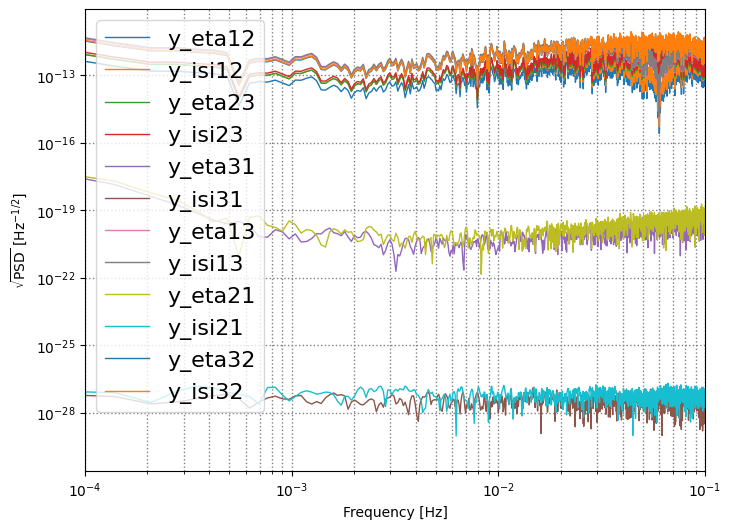

              total        used        free      shared  buff/cache   available
Mem:       15911324     7689240     5857128        1276     2364956     7910904
Swap:             0           0           0


In [35]:
import matplotlib.pyplot as plt
# Comparison with TDI variables
_, axes = plt.subplots(1, 1, figsize=(8, 6))
colors = ['blue', 'skyblue', 'red', 'orange', 'purple', 'gray']
# TDI 2.0 spectrum
for i in range(len(mosas_order)):
    axes.loglog(f[ipos], (1+i*3)*np.abs(y_fft[i][ipos]), 
            label='y_eta'+mosas_order[i], linewidth=1)
    axes.loglog(f[ipos], (2+i*3)*np.abs(y_isi_fft[i][ipos]), 
            label='y_isi'+mosas_order[i], linewidth=1)

axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"$\mathrm{\sqrt{PSD}}$ [$\mathrm{Hz^{-1/2}}$]")
plt.legend(loc='upper left', fontsize=16)
# axes.set_ylim([1e-24, 1e-17])
axes.set_xlim([1e-4, 1e-1])
#plt.title("PCI 2.0 (" + str(int(ns/fs/3600))+" hours, nh = "+str(nhalf)+")")
plt.grid(linewidth=1.0, 
         color='gray', 
         linestyle='dotted', 
         which='both', 
         axis='both')
plt.show()
!free

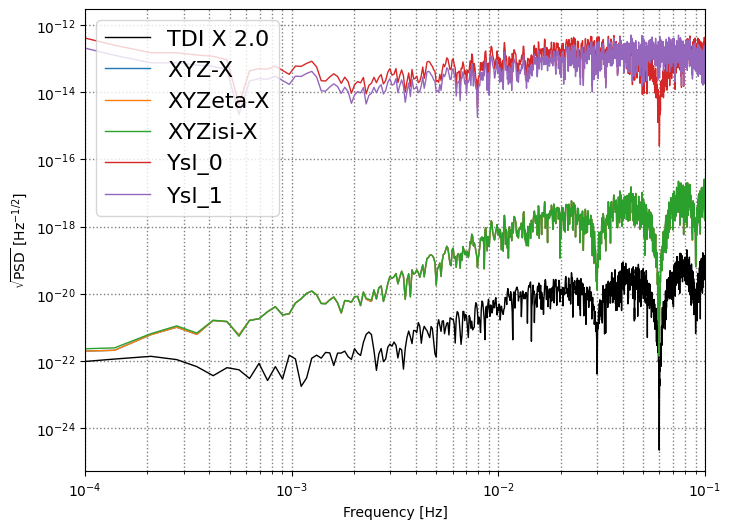

              total        used        free      shared  buff/cache   available
Mem:       15911324     7710828     5835540        1276     2364956     7889316
Swap:             0           0           0


In [36]:
import matplotlib.pyplot as plt
# Comparison with TDI variables
_, axes = plt.subplots(1, 1, figsize=(8, 6))
colors = ['blue', 'skyblue', 'red', 'orange', 'purple', 'gray']
# TDI 2.0 spectrum
axes.loglog(f[ipos], np.abs(x2_fft[ipos]), 
            label='TDI X 2.0', 
            color='black', linewidth=1)

axes.loglog(f[ipos], np.abs(XYZ_fft[0][ipos]), 
            label='XYZ-X', linewidth=1)
axes.loglog(f[ipos], np.abs(XYZc_fft[0][ipos]), 
            label='XYZeta-X', linewidth=1)
axes.loglog(f[ipos], np.abs(XYZ_isi_fft[0][ipos]), 
            label='XYZisi-X', linewidth=1)

axes.loglog(f[ipos], np.abs(Ysl0_fft[ipos]), 
            label='Ysl_0', linewidth=1)
axes.loglog(f[ipos], np.abs(Ysl1_fft[ipos]), 
            label='Ysl_1', linewidth=1)

axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"$\mathrm{\sqrt{PSD}}$ [$\mathrm{Hz^{-1/2}}$]")
plt.legend(loc='upper left', fontsize=16)
# axes.set_ylim([1e-24, 1e-17])
axes.set_xlim([1e-4, 1e-1])
#plt.title("PCI 2.0 (" + str(int(ns/fs/3600))+" hours, nh = "+str(nhalf)+")")
plt.grid(linewidth=1.0, 
         color='gray', 
         linestyle='dotted', 
         which='both', 
         axis='both')
plt.show()
!free

Using the etas, it looks like the XYZ and XYZc are at least nearly doing the right thing.  The performance deficit vs the formal TDI may be because we are using a constant kernel produced from the initial time.  This is supported by the evidence that the is about 300 on 12 hrs of data but only about 30 on 1/2 hr of data.  

On the new-code's 2025-04-07 data the etas and isi's are nearly the same, so it works either way.

Let's see what happens with a time varying implementation.

In [37]:

from pyfftw.interfaces.numpy_fft import rfft

def do_ft(dataset, fs=fs):
    ns=dataset.n_samples()
    wd=np.blackman(ns)
    f = np.fft.rfftfreq(ns) * fs
    sel=f>0
    print(sel)
    dataset_fft=[rfft(wd * dataset.data[i] ) * np.sqrt(2/(fs*k2)) for i in range(dataset.n_channels())]
    
    return f[sel], np.array(dataset_fft)[:,sel]


XYZ_file_noise = TimeData(np.array([x2_noise,y2_noise,z2_noise], dtype=np.float64)[:,skip:],dt=1/fs,names='XYZ')


[False  True  True ...  True  True  True]
[3.86174937e-06 7.72349874e-06 1.15852481e-05 ... 1.99999228e+00
 1.99999614e+00 2.00000000e+00]
[False  True  True ...  True  True  True]
[False  True  True ...  True  True  True]
[False  True  True ...  True  True  True]
[False  True  True ...  True  True  True]
              total        used        free      shared  buff/cache   available
Mem:       15911324     7968200     5578160        1276     2364964     7631944
Swap:             0           0           0


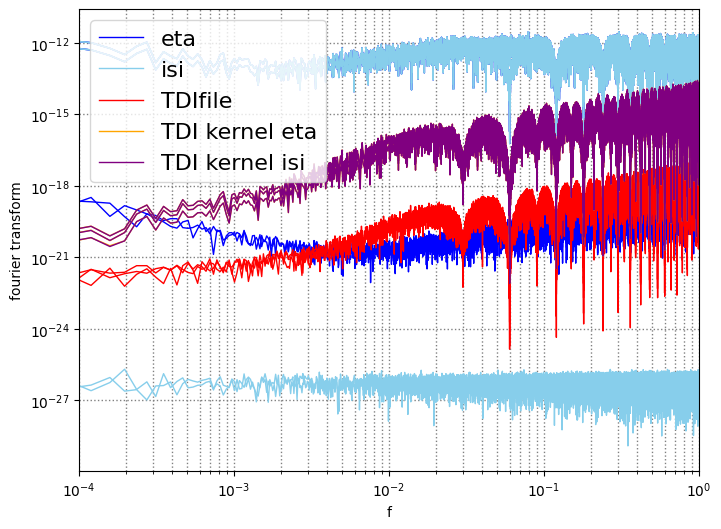

In [38]:
# View data in freq domain

import matplotlib.pyplot as plt
# Comparison with TDI variables
_, axes = plt.subplots(1, 1, figsize=(8, 6))
colors = ['blue', 'skyblue', 'red', 'orange', 'purple', 'gray']
# TDI 2.0 

iev = 10
i0=iev

f,data=do_ft(y_td)
axes.loglog(f[i0::iev], np.abs(data[0,i0::iev]), linewidth=1, color=colors[0], label='eta')
for i in range(1,6):
    axes.loglog(f[i0::iev], np.abs(data[i,i0::iev]), linewidth=1, color=colors[0])
    
print(f)    
f,data=do_ft(y_isi_td)
axes.loglog(f[i0::iev], np.abs(data[0,i0::iev]), linewidth=1, color=colors[1], label='isi')
for i in range(1,6):
    axes.loglog(f[i0::iev], np.abs(data[i,i0::iev]), linewidth=1, color=colors[1])
    
f,data=do_ft(XYZ_file_noise)
axes.loglog(f[i0::iev], np.abs(data[0,i0::iev]), linewidth=1, color=colors[2], label='TDIfile')
for i in range(1,3):
    axes.loglog(f[i0::iev], np.abs(data[i,i0::iev]), linewidth=1, color=colors[2])
        
f,data=do_ft(XYZ)
axes.loglog(f[i0::iev], np.abs(data[0,i0::iev]), linewidth=1, color=colors[3], label='TDI kernel eta')
for i in range(1,3):
    axes.loglog(f[i0::iev], np.abs(data[i,i0::iev]), linewidth=1, color=colors[3])
    
f,data=do_ft(XYZ_isi)
axes.loglog(f[i0::iev], np.abs(data[0,i0::iev]), linewidth=1, color=colors[4], label='TDI kernel isi')
for i in range(1,3):
    axes.loglog(f[i0::iev], np.abs(data[i,i0::iev]), linewidth=1, color=colors[4])

    
    
axes.set_xlabel("f")
axes.set_ylabel(r"fourier transform")
plt.legend(loc='upper left', fontsize=16)
# axes.set_ylim([1e-24, 1e-17])
axes.set_xlim([1e-4, 1])
#plt.title("PCI 2.0 (" + str(int(ns/fs/3600))+" hours, nh = "+str(nhalf)+")")
plt.grid(linewidth=1.0, 
         color='gray', 
         linestyle='dotted', 
         which='both', 
         axis='both')
#plt.show()
!free

## More precise reverse engineering
More precisely, what we apply in our filtering code is a kernel or filter kernel which is based combines various time-shifted samples of the input streams to get a single time sample of the output streams. The above treatment estimates the kernel from the impulse response at one moment of the input which contributes to several time-shifted samples of output.  These are equivalent in the limit that the kernel doesn't vary with sample time.  We find that we cannot completely ignore the evolution of the kernel even across its width, though, so we need a more accurate version. 

In [39]:
###Now we reorganize pack that all into a neat bundle
def compute_TDI_kernel_exact(noise_data,i0=0,pastwidth=500,buffer=0):
    # This version applies input impulse response across with impulses across the full width of the kernel 
    # but response only taken from the i0 point.
    # It may be somewhat slow, so that an approximation might be considered...TBD
    # For simplicity, we only treat the case where the kernel is strictly non-future-supported 
    #
    # pastwidth should be the full width of the (past-dominated) kernel which also includes i0
    # buffer is extra width on each side to include in the impulse response calculation
    
    mosas_order = ['12', '23', '31', '13', '21', '32']
    nchan_in=6  #hard-coded for now
    
    # 1. First we restrict to a relevant stretch of data
    istart=i0-(pastwidth-1)-buffer
    iend=i0+buffer+pastwidth #We add pastwidth to ensure that there is room for the forward kernel from i0
    assert istart>=0, "out of range at start"

    #make modified version of the data_noise args
    newargs=copy.deepcopy(noise_data.args)
    for k in newargs['delays'].keys():
        #print(k,newargs['delays'][k].shape,newargs['delay_derivatives'][k].shape)
        newargs['delays'][k]=newargs['delays'][k][istart:iend]
        newargs['delay_derivatives'][k]=newargs['delay_derivatives'][k][istart:iend]
    XYZ_ops=[chan.build(**newargs) for chan in [X2,Y2,Z2]]
    #display(newargs)

    #Compute the zero-response for the relevant stretch of data
    measurements_z=copy.deepcopy(noise_data.measurements)
    for k in measurements_z.keys():
        #print(k,measurements[k].shape)
        measurements_z[k]=measurements_z[k][istart:iend]

    for link in mosas_order:
        name=f'isi_{link}'
        data=np.zeros((iend-istart,))
        measurements_z[name]=data
    #print('computing TDI')
    XYZ_z=np.array([op(measurements_z) for op in XYZ_ops])
    #print(XYZ_z)

    # 2. Get the zero-response
    XYZ_z=np.array([op(measurements_z) for op in XYZ_ops])[:,i0-istart]

    # 3. Now get the single-point-impulse-responses to populate the kernel
    kernel = np.zeros((3,pastwidth,nchan_in))
    for ilink in range(nchan_in):
        link=mosas_order[ilink]
        print(link)
        for j in range(pastwidth): #loop over points in the kernel
            measurements_1=copy.deepcopy(measurements_z)
            name=f'isi_{link}'
            measurements_1[name][i0-j-istart]=1
            kernel[:,pastwidth-j-1,ilink]=np.array([op(measurements_1) for op in XYZ_ops])[:,i0-istart]-XYZ_z

    return kernel

###Now we reorganize pack that all into a neat bundle
def compute_TDI_kernel_linear(noise_data,i0=0,pastwidth=500,buffer=20):
    # This version applies input impulse response across with impulses at each end of the kernel spanning
    # the pastwidth and linearly interpolates inbetween.
    #
    # pastwidth should be the full width of the (past-dominated) kernel which also includes i0
    # buffer is extra width on each side to include in the impulse response calculation
    
    mosas_order = ['12', '23', '31', '13', '21', '32']
    nchan_in=6  #hard-coded for now
    
    # 1. First we restrict to a relevant stretch of data
    istart=i0-(pastwidth-1)-buffer
    iend=i0+buffer+pastwidth #We add pastwidth to ensure that there is room for the forward kernel from i0
    assert istart>=0, "out of range at start"

    #make modified version of the data_noise args
    newargs=copy.deepcopy(noise_data.args)
    for k in newargs['delays'].keys():
        #print(k,newargs['delays'][k].shape,newargs['delay_derivatives'][k].shape)
        newargs['delays'][k]=newargs['delays'][k][istart:iend]
        newargs['delay_derivatives'][k]=newargs['delay_derivatives'][k][istart:iend]
    XYZ_ops=[chan.build(**newargs) for chan in [X2,Y2,Z2]]
    #display(newargs)

    #Compute the zero-response for the relevant stretch of data
    measurements_z=copy.deepcopy(noise_data.measurements)
    for k in measurements_z.keys():
        #print(k,measurements[k].shape)
        measurements_z[k]=measurements_z[k][istart:iend]

    for link in mosas_order:
        name=f'isi_{link}'
        data=np.zeros((iend-istart,))
        measurements_z[name]=data
    #print('computing TDI')
    XYZ_z=np.array([op(measurements_z) for op in XYZ_ops])
    #print(XYZ_z)

    # 2. Get the zero-response
    XYZ_z=np.array([op(measurements_z) for op in XYZ_ops])

    # 3. Now get the full set of responses for the endpoints of the kernel
    samp_points=np.array([0,pastwidth-2])
    samp_coeffs = np.zeros((2,3,pastwidth,nchan_in))
    for isamp in range(2):
        jsamp=samp_points[isamp]
        for ilink in range(nchan_in):
            link=mosas_order[ilink]
            print(link)
            measurements_1=copy.deepcopy(measurements_z)
            name=f'isi_{link}'
            iimpulse=i0-istart-jsamp
            measurements_1[name][iimpulse]=1
            samp_coeffs[isamp,:,:,ilink]=np.array([op(measurements_1) for op in XYZ_ops])[:,iimpulse:iimpulse+pastwidth]-XYZ_z[:,iimpulse:iimpulse+pastwidth]

    # 4. Now interpolate
    samp_coeffs=samp_coeffs.transpose(0,1,3,2)
    ioff=list(range(pastwidth))
    eps = (ioff-samp_points[0])/(samp_points[1]-samp_points[0])
    kernel=samp_coeffs[0]*(1-eps)+samp_coeffs[1]*eps
    kernel=kernel.transpose(0,2,1)[:,::-1,:]
    
    return kernel#,samp_coeffs.transpose(0,1,3,2)

In [40]:
i0test=5000
_,so=compute_TDI_kernel(data_noise,i0=i0test,nleft=1000,nright=2000)
se=compute_TDI_kernel_exact(data_noise,i0=i0test,pastwidth=250)
sl=compute_TDI_kernel_linear(data_noise,i0=i0test,pastwidth=250,buffer=30)

length,first,last 250 1000 1249
ioff 0
12
23
31
13
21
32
12
23
31
13
21
32
12
23
31
13
21
32


-c-e -2.0 2.0 0.1999032309503347
l-e -8.110512261794156e-12 6.713796185664478e-12 4.508701277244666e-13
-2.102472940447271e-08 1.8950721983251298e-07 3.0505732036632574e-09


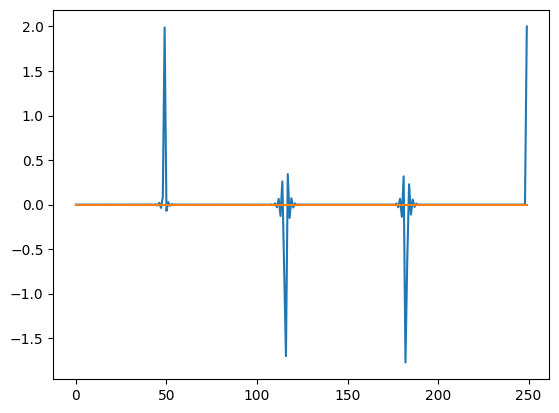

In [41]:
#Compare (-1)*old vs exact kernels
deltac = -so - se
delta = sl - se
plt.plot((-so-se)[0,:,0])
plt.plot((sl-se)[0,:,0])
#plt.plot(sl[0,:,0]-se[0,:,0])
print('-c-e',np.min(deltac),np.max(deltac),np.std(deltac))
print('l-e',np.min(delta),np.max(delta),np.std(delta))
deltarel=delta/[1e-300+se]
print(np.min(deltarel),np.max(deltarel),np.std(deltarel))


In [42]:
#Compare code vs old kernels
sc=tdifilt.kernel_compts
#display(sc)
#display(so)
delta = sc - so
#display(delta)
print(np.min(delta),np.max(delta),np.std(delta))
deltarel=delta/[1e-300+sc]
print(np.min(deltarel),np.max(deltarel),np.std(deltarel))

-7.840921949814339e-05 8.080533204729567e-05 4.442790790811848e-06
-0.02681845987222337 0.0005861880862131571 0.002257938745368301


In [44]:
test_hours = 1
test_len =  int(test_hours * 3600 * fs)
ytest=TimeData(y_full_isi[0:test_len,:].T, dt=1/fs,names=tdifilt.input_names)
print(ytest.data.shape)

XYZcode=tdifilt.apply_filter(ytest,method='convolve')

tdifilt_se=TDIFilter(data_noise,eval_time=1000/fs)
tdifilt_se.kernel_compts=se
XYZse=tdifilt_se.apply_filter(ytest,method='convolve')

tdifilt_sl=TDIFilter(data_noise,eval_time=1000/fs)
tdifilt_sl.kernel_compts=sl
XYZsl=tdifilt_sl.apply_filter(ytest,method='convolve')

(6, 14400)


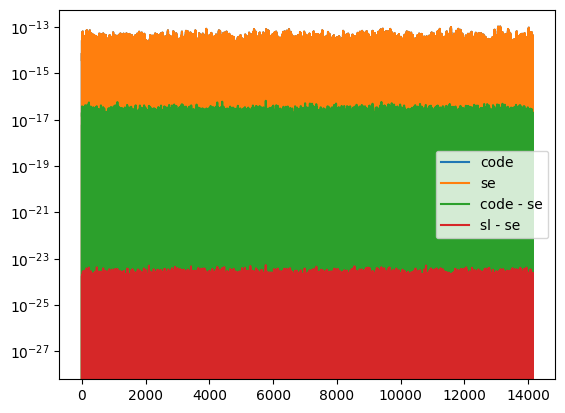

In [45]:
ixyz=0
iev=1
ist=0
iend=20000
plt.semilogy(XYZcode.data[ixyz][ist:iend:iev],label="code")
plt.semilogy(XYZse.data[ixyz][ist:iend:iev],label="se")
#plt.semilogy(XYZcode.data[ixyz]-XYZse.data[ixyz],label="code - se")
plt.semilogy((XYZcode.data[ixyz]-XYZse.data[ixyz])[ist:iend:iev],label="code - se")
plt.semilogy((XYZsl.data[ixyz]-XYZse.data[ixyz])[ist:iend:iev],label="sl - se")
plt.legend()

[False  True  True ...  True  True  True]
[False  True  True ...  True  True  True]
[False  True  True ...  True  True  True]
[False  True  True ...  True  True  True]


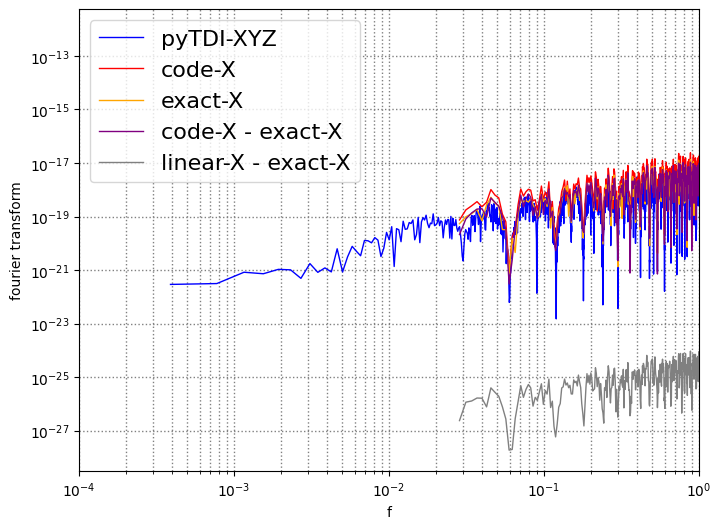

In [46]:
# Comparison with TDI variables
_, axes = plt.subplots(1, 1, figsize=(8, 6))
colors = ['blue', 'red', 'orange', 'purple', 'gray']
# TDI 2.0 
ixyz=0
iev = 100
i0=iev

f,data=do_ft(XYZ_file_noise)
axes.loglog(f[i0::iev], np.abs(data[ixyz,i0::iev]), linewidth=1, color=colors[0], label='pyTDI-'+'XYZ')

iev=10

f,data=do_ft(XYZcode)
datac=data
axes.loglog(f[i0::iev], np.abs(data[ixyz,i0::iev]), linewidth=1, color=colors[1], label='code-'+'XYZ'[ixyz])
    
f,data=do_ft(XYZse)
datae=data
axes.loglog(f[i0::iev], np.abs(data[ixyz,i0::iev]), linewidth=1, color=colors[2], label='exact-'+'XYZ'[ixyz])

data=datac-datae
axes.loglog(f[i0::iev], np.abs(data[ixyz,i0::iev]), linewidth=1, color=colors[3], label='code-'+'XYZ'[ixyz]+' - exact-'+'XYZ'[ixyz])

f,data=do_ft(XYZsl)
datal=data
data=datal-datae
axes.loglog(f[i0::iev], np.abs(data[ixyz,i0::iev]), linewidth=1, color=colors[4], label='linear-'+'XYZ'[ixyz]+' - exact-'+'XYZ'[ixyz])

    
    
axes.set_xlabel("f")
axes.set_ylabel(r"fourier transform")
plt.legend(loc='upper left', fontsize=16)
# axes.set_ylim([1e-24, 1e-17])
axes.set_xlim([1e-4, 1])
#plt.title("PCI 2.0 (" + str(int(ns/fs/3600))+" hours, nh = "+str(nhalf)+")")
plt.grid(linewidth=1.0, 
         color='gray', 
         linestyle='dotted', 
         which='both', 
         axis='both')
#plt.show()

With equalarm data, the exact and code kernels agree to a part in 1e7 or so and the filtered data have a level 1e-18, and agree to a part in 1e5. The linear and exact filtered cata agree to a part in 1e8.

With kepler the suppression is only to 1e-13 but I am not seeing the near-kernel optimum I expect